<div align="center">

#### Lab 3

# National Tsing Hua University

#### Spring 2025

#### 11320IEEM 513600

#### Deep Learning and Industrial Applications
    
## Lab 3: Anomaly Detection in Industrial Applications

</div>

### Introduction

In today's industrial landscape, the ability to detect anomalies in manufacturing processes and products is critical for maintaining quality, efficiency, and safety. This lab focuses on leveraging deep learning techniques for anomaly detection in various industrial applications, using the MVTEC Anomaly Detection Dataset. By employing ImageNet-pretrained models available in torchvision, students will gain hands-on experience in classfying defects and irregularities across different types of industrial products.

Throughout this lab, you'll be involved in the following key activities:
- Explore and process the MVTec Anomaly Detection Dataset.
- Apply ImageNet-pretrained models from [Torchvision](https://pytorch.org/vision/stable/models.html) to detect anomalies in industrial products.
- Evaluate the performance of the models to understand their effectiveness in real-world industrial applications.

### Objectives

- Understand the principles of anomaly detection in the context of industrial applications.
- Learn how to implement and utilize ImageNet-pretrained models for detecting anomalies.
- Analyze and interpret the results of the anomaly detection models to assess their practicality in industrial settings.

### Dataset

The MVTec AD Dataset is a comprehensive collection of high-resolution images across different categories of industrial products, such as bottles, cables, and metal nuts, each with various types of defects. This dataset is pivotal for developing and benchmarking anomaly detection algorithms. You can download our lab's dataset [here](https://drive.google.com/file/d/19600hUOpx0hl78TdpdH0oyy-gGTk_F_o/view?usp=share_link). You can drop downloaded data and drop to colab, or you can put into yor google drive.

### References
- [MVTec AD Dataset](https://www.kaggle.com/datasets/ipythonx/mvtec-ad/data) for the dataset used in this lab.
- [Torchvision Models](https://pytorch.org/vision/stable/models.html) for accessing ImageNet-pretrained models to be used in anomaly detection tasks.
- [State-of-the-Art Anomaly Detection on MVTec AD](https://paperswithcode.com/sota/anomaly-detection-on-mvtec-ad) for insights into the latest benchmarks and methodologies in anomaly detection applied to the MVTec AD dataset.
- [CVPR 2019: MVTec AD — A Comprehensive Real-World Dataset for Unsupervised Anomaly Detection] for the original paper of MVTec AD dataset.

In [1]:
import glob
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
from tqdm import tqdm
import torch
from collections import defaultdict
import os

In [2]:
!unzip "transistor.zip" -d "transistor"

Archive:  transistor.zip
   creating: transistor/transistor/
   creating: transistor/transistor/test/
   creating: transistor/transistor/test/bent_lead/
  inflating: transistor/transistor/test/bent_lead/000.png  
  inflating: transistor/transistor/test/bent_lead/001.png  
  inflating: transistor/transistor/test/bent_lead/002.png  
  inflating: transistor/transistor/test/bent_lead/003.png  
  inflating: transistor/transistor/test/bent_lead/004.png  
  inflating: transistor/transistor/test/bent_lead/005.png  
  inflating: transistor/transistor/test/bent_lead/006.png  
  inflating: transistor/transistor/test/bent_lead/007.png  
  inflating: transistor/transistor/test/bent_lead/008.png  
  inflating: transistor/transistor/test/bent_lead/009.png  
   creating: transistor/transistor/test/cut_lead/
  inflating: transistor/transistor/test/cut_lead/000.png  
  inflating: transistor/transistor/test/cut_lead/001.png  
  inflating: transistor/transistor/test/cut_lead/002.png  
  inflating: transis

In [28]:
base_path = '/content/transistor/transistor'
file_paths = glob.glob(f'{base_path}/train/good/*.png') + glob.glob(f'{base_path}/test/*/*.png')

print(f"{len(file_paths)}")

313


In [29]:
class_names = ['good', 'bent_lead', 'cut_lead', 'damaged_case', 'misplaced']
label_map = {name: i for i, name in enumerate(class_names)}

In [30]:
class_data = defaultdict(list)
target_size = (256, 256)

for path in tqdm(file_paths):
    img = cv2.imread(path)
    if img is None:
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)

    if 'train' in path:
        class_name = 'good'
    else:
        class_name = path.split('/')[-2]

    if class_name in class_names:
        class_data[class_name].append(img)

  0%|          | 0/313 [00:00<?, ?it/s]

In [31]:
x_train, y_train, x_val, y_val = [], [], [], []
train_ratio = 0.8

for class_name in class_names:
    imgs = class_data[class_name]
    n = len(imgs)
    split = int(n * train_ratio)

    x_train.extend(imgs[:split])
    y_train.extend([label_map[class_name]] * split)

    x_val.extend(imgs[split:])
    y_val.extend([label_map[class_name]] * (n - split))

    print(f"{class_name}：共 {n} 張圖，訓練 {split}，驗證 {n - split}")

good：共 273 張圖，訓練 218，驗證 55
bent_lead：共 10 張圖，訓練 8，驗證 2
cut_lead：共 10 張圖，訓練 8，驗證 2
damaged_case：共 10 張圖，訓練 8，驗證 2
misplaced：共 10 張圖，訓練 8，驗證 2


In [32]:
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_val = np.transpose(np.array(x_val), (0, 3, 1, 2))
y_train = np.array(y_train)
y_val = np.array(y_val)

print(f"\nx_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_val:   {x_val.shape}, y_val:   {y_val.shape}")
print(f"{label_map}")


x_train: (250, 3, 256, 256), y_train: (250,)
x_val:   (63, 3, 256, 256), y_val:   (63,)
{'good': 0, 'bent_lead': 1, 'cut_lead': 2, 'damaged_case': 3, 'misplaced': 4}


In [33]:
# import matplotlib.pyplot as plt
# import numpy as np

# classes = sorted(set([path.split('/')[4] for path in file_paths]))
# print(f'Classes: {classes}')

# images_per_class = len(all_data) // len(classes)
# fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

# for i, class_name in enumerate(classes):
#     index = i * images_per_class
#     for j in range(2):
#         axs[i, j].set_title(f'{i}. {class_name}')
#         axs[i, j].imshow(all_data[index + j])
#         axs[i, j].axis('off')

# plt.tight_layout() # 自動調整子圖間距
# plt.show()

## A. Data Loading and Preprocessing

In [34]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

train_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.AutoAugment(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15), #attempt 1
        transforms.ToTensor(), # 轉為 PyTorch Tensor，值域變成 [0, 1]
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
    ]
)

class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x  # x 是圖片資料，shape 通常為 (N, 3, H, W)
        self.y = torch.from_numpy(y).long() # y 是 label，轉為 PyTorch tensor
        self.transform = transform

    def __len__(self):
        return len(self.x) # 讓 PyTorch 知道有幾筆資料

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0)) # 將 NumPy 圖片轉成 PIL 圖像 (C, H, W) ➜ (H, W, C)，符合 PIL 需求
        return self.transform(Image.fromarray(new_x)), self.y[idx]

In [35]:
# 用 PyTorch 的 DataLoader 將定義好的 MyDataset 包成可訓練用的批次資料載入器
batch_size = 32

train_dataset = MyDataset(x_train, y_train, train_transforms)
val_dataset = MyDataset(x_val, y_val, val_transforms)

# 每次提供訓練資料 batch 給模型
# num_workers 用2條平行處理程序來加速讀資料
# pin_memory 資料固定在 RAM，GPU 輸入更快
# persistent_workers 多輪 epoch 間保留 worker 不關閉
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, num_workers=1, pin_memory=True, persistent_workers=True)

## B. Defining Neural Networks

In [36]:
# ResNet-18 預訓練模型，不更新參數，只訓練最後一層來做 8 類分類任務
# Transfer Learning
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# model = models.resnet18(weights='IMAGENET1K_V1') #使用ImageNet上訓練好的權重（IMAGENET1K_V1）原本的最後一層分類是1000類（ImageNet的類別數）

# # ConvNet as fixed feature extractor (freeze parameters)
# # 只會訓練自己加上去的最後一層，把 ResNet 當作固定的特徵提取器
# for param in model.parameters():
#     param.requires_grad = False
##################################################### attempt 2
model = models.resnet50(weights='IMAGENET1K_V1')
for name, param in model.named_parameters():
    if 'layer4' in name or 'fc' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
#####################################################
# 把最後一層換掉（改成8類輸出）
num_ftrs = model.fc.in_features
num_class = 5

# change # of class from 1000 into 5 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## C. Training the Neural Network

In [37]:
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
from tqdm.auto import tqdm

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

epochs = 50
model = model.cuda() # 把模型搬到GPU

best_val_loss = float('inf')
best_val_acc = -1

criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
# lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*epochs, eta_min=0)
################attempt 3
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
################

for epoch in tqdm(range(epochs)):
    # Training
    model.train()
    total_loss = 0.0
    train_correct = 0
    total_train_samples = 0

    for images, labels in train_loader:
        images = images.cuda()
        #images = (images) / 255. #正規化
        labels = labels.cuda()
        optimizer.zero_grad() #清空梯度
        outputs = model(images) #前向傳播

        labels = labels.long()

        loss = criterion(outputs, labels)
        loss.backward() #反向傳播
        optimizer.step() #更新參數
        total_loss += loss.item()

        train_predicted = outputs.argmax(-1) #預測結果
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples

    # Validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad(): # 驗證不需要梯度，沒有 backward 和 optimizer
        for images, labels in val_loader:
            images = images.cuda()
            #images = (images) / 255.
            labels = labels.cuda()
            outputs = model(images)

            labels = labels.long()

            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100. * correct / total

    # Learning rate update 每個epoch結束後更新學習率
    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss

    if val_accuracy > best_val_acc:
        best_val_acc = val_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {val_accuracy:.4f}%, Best Val loss: {best_val_loss:.4f} Best Val acc: {best_val_acc:.2f}%')

    # Store performance
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1/50, Train loss: 1.3325, Train acc: 47.6000%, Val loss: 1.0744, Val acc: 84.1270%, Best Val loss: 1.0744 Best Val acc: 84.13%
Epoch 2/50, Train loss: 0.7158, Train acc: 87.2000%, Val loss: 0.7555, Val acc: 87.3016%, Best Val loss: 0.7555 Best Val acc: 87.30%
Epoch 3/50, Train loss: 0.5879, Train acc: 87.2000%, Val loss: 0.8645, Val acc: 87.3016%, Best Val loss: 0.7555 Best Val acc: 87.30%
Epoch 4/50, Train loss: 0.5681, Train acc: 87.2000%, Val loss: 0.7201, Val acc: 87.3016%, Best Val loss: 0.7201 Best Val acc: 87.30%
Epoch 5/50, Train loss: 0.5661, Train acc: 87.2000%, Val loss: 0.6053, Val acc: 87.3016%, Best Val loss: 0.6053 Best Val acc: 87.30%
Epoch 6/50, Train loss: 0.5262, Train acc: 87.2000%, Val loss: 0.5663, Val acc: 87.3016%, Best Val loss: 0.5663 Best Val acc: 87.30%
Epoch 7/50, Train loss: 0.5240, Train acc: 87.2000%, Val loss: 0.5424, Val acc: 87.3016%, Best Val loss: 0.5424 Best Val acc: 87.30%
Epoch 8/50, Train loss: 0.5077, Train acc: 87.2000%, Val loss: 0.5970

### Visualizing model performance

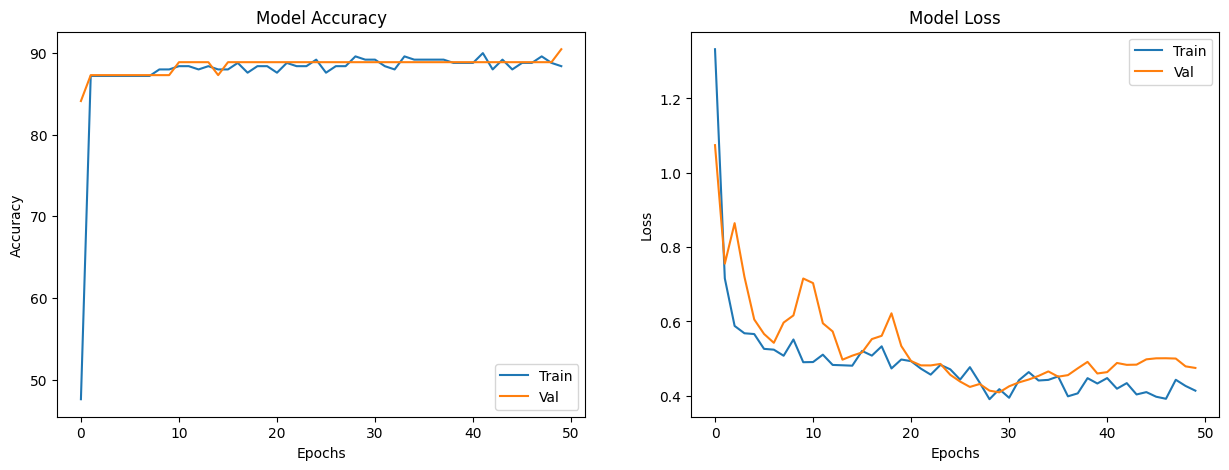

In [38]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5)) #1列2行

# ax[0] 第一張圖（畫準確率）
# Plotting training and validation accuracy
ax[0].plot(train_accuracies)
ax[0].plot(val_accuracies)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# ax[1] 第二張圖（畫損失）
# Plotting training and validation loss
ax[1].plot(train_losses)
ax[1].plot(val_losses)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

## D. Evaluating Your Trained Model

### Load Trained Model and Evaluate

In [39]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.cuda()
        #images = (images) / 255.

        labels = labels.cuda()
        labels = labels.long()

        outputs = model(images) # 模型預測 logits

        predicted = outputs.argmax(-1) # 取最大值所在位置（類別）
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 4], device='cuda:0')
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 2, 2, 3, 3, 4, 4], device='cuda:0')
Test accuracy is 90.47619047619048%
